# Ratio KE/PE
### Computes the spectral ratio between ocean KE and PE at the surface using CROCO


In [52]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import seawater as sw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar

import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [4]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [8]:
dxx=0.5
dyy=dxx

In [6]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

In [7]:
varf

<xarray.Dataset>
Dimensions:              (y_rho: 1520, x_rho: 1000, y_u: 1520, x_u: 999, y_v: 1519, x_v: 1000, y_w: 1520, x_w: 1000, time_counter: 852, axis_nbounds: 2)
Coordinates:
    nav_lat_rho          (y_rho, x_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lon_rho          (y_rho, x_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lat_u            (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    nav_lon_u            (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    nav_lat_v            (y_v, x_v) float32 dask.array<chunksize=(1519, 1000), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 dask.array<chunksize=(1519, 1000), meta=np.ndarray>
    nav_lat_w            (y_w, x_w) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lon_w            (y_w, x_w) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    time_instant         (time_counter) datetime64[ns] dask.array<chunksize=(124,), meta=np.ndarray>
  * time_counter         (time_counter) datetime64[ns] 2012-01-01T06:00:00 .....
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, y_w, x_w, axis_nbounds
Data variables: (12/43)
    s_rho                float32 -0.00625
    s_w                  float32 0.0
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
    hc                   float64 200.0
    theta_s              float64 6.0
    ...                   ...
    v                    (time_counter, y_v, x_v) float32 dask.array<chunksize=(124, 1519, 1000), meta=np.ndarray>
    w                    (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    omega                (time_counter, y_w, x_w) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    temp                 (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    salt                 (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    rho                  (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
Attributes: (12/49)
    name:                      Out/AVG_Y2012M01/SASI_6h_his
    description:               Created by xios
    Conventions:               CF-1.6
    timeStamp:                 2020-Jul-30 22:12:58 GMT
    uuid:                      1e6e6c86-13c6-4527-ac3f-51b9c243770b
    title:                     SASI
    ...                        ...
    sponge_expl:               Sponge parameters : extent (m) & viscosity (m2...
    SRCS:                      main.F step.F read_inp.F timers_roms.F init_sc...
    CPP-options:               REGIONAL SASI DIAGNOSTICS_EDDY DIAGNOSTICS_TS ...
    history:                   Sun Apr 17 12:57:27 2022: ncwa -a s_rho tmp2.n...
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

## Calculating surface PE

In [9]:
chunks_new={'time_counter':120}

In [10]:
%%time


tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();


CPU times: user 5.59 s, sys: 7.93 s, total: 13.5 s
Wall time: 31.2 s


In [11]:
sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:800].compute();

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:800].compute();

In [12]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [53]:
alphaf=sw.alpha(sf,tf,p=0)
alphat=sw.alpha(st,tt,p=0)
betaf=sw.beta(s=sf,t=tf,p=0)
betat=sw.beta(s=st,t=tt,p=0)
g=9.8

In [155]:
sw.beta?

Signature: sw.beta(s, t, p, pt=False)
Docstring:
Calculate the saline contraction coefficient :math:`\beta` as defined
by T.J. McDougall.

Parameters
----------
s(p) : array_like
       salinity [psu (PSS-78)]
t(p) : array_like
       temperature or potential temperature [℃ (ITS-90)]
p : array_like
    pressure [db].
pt : bool
     True if temperature is potential, default is False

Returns
-------
beta : array_like
       saline Contraction Coefficient [psu :sup:`-1`]

Examples
--------
>>> # Data from McDougall 1987
>>> import seawater as sw
>>> s, t, p = 40, 10, 4000
>>> sw.beta(s, t, p, pt=True)
0.00072087661741618932

References
----------
.. [1] McDougall, Trevor J., 1987: Neutral Surfaces. J. Phys. Oceanogr.,
   17, 1950-1964. doi: 10.1175/1520-0485(1987)017<1950:NS>2.0.CO;2
File:      ~/miniconda3/envs/ROMS/lib/python3.7/site-packages/seawater/eos80.py
Type:      function


In [153]:
betaf[0].mean()

0.0007578391

In [96]:
bf=-(g/1025)*(rhof-1025)
bt=-(g/1025)*(rhot-1025)

# bf=xroms.buoyancy(rhof-1025)#[:,1:-1,:]
# bt=xroms.buoyancy(rhot-1025)#[:,1:-1,:]

In [19]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [97]:
%%time
with ProgressBar():
    alphaBf=xrft.isotropic_power_spectrum((alphaf*g*(tf-tf.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    alphaBt=xrft.isotropic_power_spectrum((alphat*g*(tt-tt.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

CPU times: user 34min 19s, sys: 1h 50min 32s, total: 2h 24min 51s
Wall time: 3min 30s


In [100]:

with ProgressBar():
    betaBf=xrft.isotropic_power_spectrum((-betaf*g*(sf-sf.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    betaBt=xrft.isotropic_power_spectrum((-betat*g*(st-st.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [101]:
%%time
with ProgressBar():
    Bf=xrft.isotropic_power_spectrum(bf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Bt=xrft.isotropic_power_spectrum(bt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

CPU times: user 33min 38s, sys: 1h 45min 31s, total: 2h 19min 10s
Wall time: 3min 16s


In [102]:
N2r=(5.2*10**-3)**2

In [103]:
Epe_alpha_f=(1/(2*N2r))*alphaBf
Epe_alpha_t=(1/(2*N2r))*alphaBt
Epe_beta_f=(1/(2*N2r))*betaBf
Epe_beta_t=(1/(2*N2r))*betaBt

In [106]:
Epef=(1/(2*N2r))*Bf
Epet=(1/(2*N2r))*Bt

## Calculating surface KE

In [23]:
%%time
uf=varf.u#.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u#.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v#.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v#.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 11.9 s, sys: 22.9 s, total: 34.8 s
Wall time: 17.6 s


In [24]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [25]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [26]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))

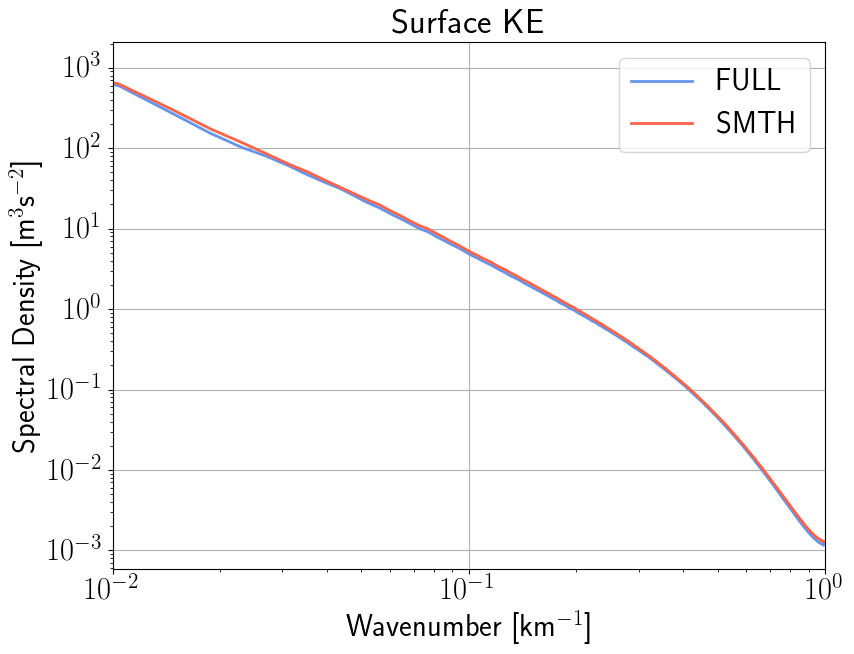

In [159]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),Ekef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),Eket.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')

plt.title(r'Surface KE ',fontsize=25,fontweight='bold')
plt.yscale('log')
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()

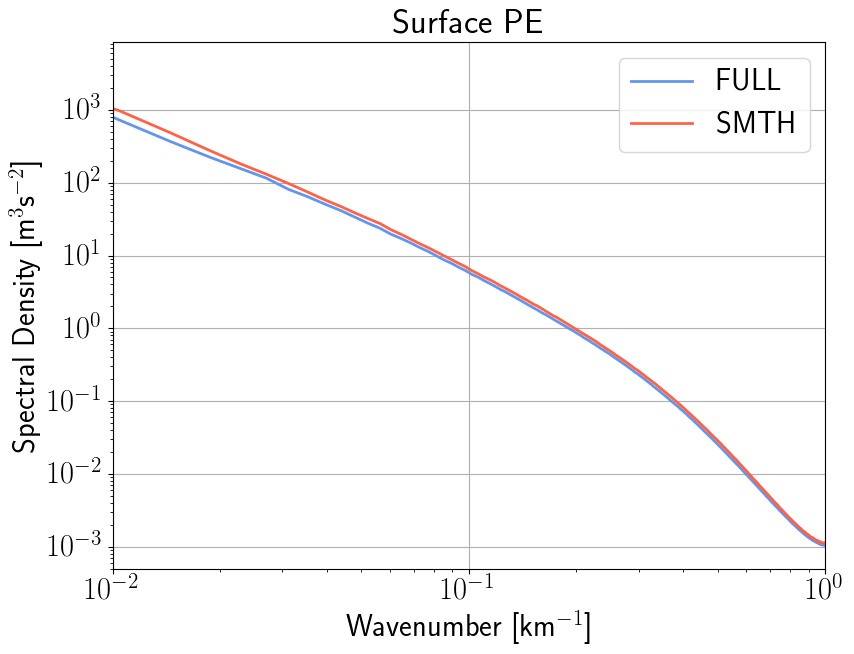

In [160]:

plt.figure(figsize=(9,7))


plt.plot((Epef.freq_r/dxx),Epef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epet.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')


plt.title(r'Surface PE',fontsize=25,fontweight='bold')
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')
plt.yscale('log')


# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()

# Thermal and haline PE components

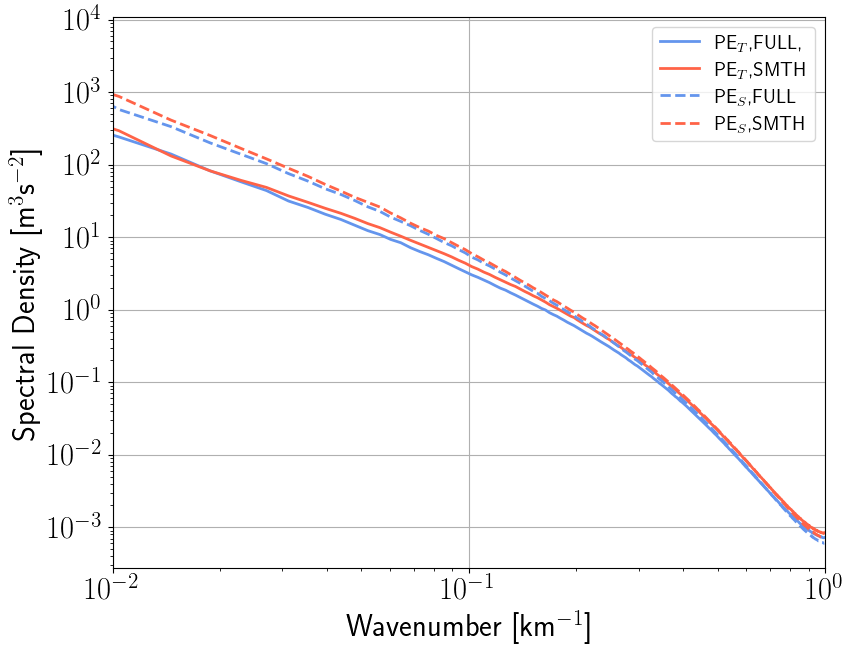

In [161]:
plt.figure(figsize=(9,7))


plt.plot((Epef.freq_r/dxx),Epe_alpha_f.mean(axis=0)/dxx*1e3,label=r'PE$_T$,FULL,',linewidth=2,color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epe_alpha_t.mean(axis=0)/dxx*1e3,label=r'PE$_T$,SMTH',linewidth=2,color='tomato')

plt.plot((Epef.freq_r/dxx),Epe_beta_f.mean(axis=0)/dxx*1e3,label=r'PE$_S$,FULL',linewidth=2,linestyle='--',color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epe_beta_t.mean(axis=0)/dxx*1e3,label=r'PE$_S$,SMTH',linewidth=2,linestyle='--',color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(fontsize=14)

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')


# plt.title(r'Surface PE',fontsize=25,fontweight='bold')
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')
plt.yscale('log')



# plt.ylim(0.001,.5)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/PEt,PEs.png')



## Plotting Ratio

In [162]:
R_f=(Ekef.data/Epef.data).mean(axis=0)
R_t=(Eket.data/Epet.data).mean(axis=0)

In [163]:
Rt_f=(Ekef.data/Epe_alpha_f.data).mean(axis=0)
Rt_t=(Eket.data/Epe_alpha_t.data).mean(axis=0)

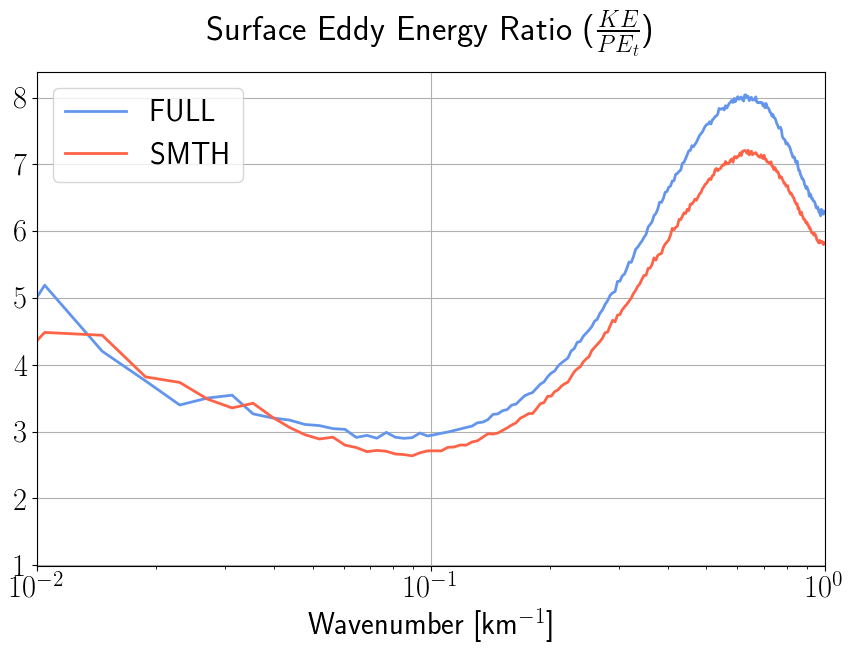

In [164]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),Rt_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),Rt_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'Surface Eddy Energy Ratio ($\frac{KE}{PE_t}$)',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_KE-PEt.png')



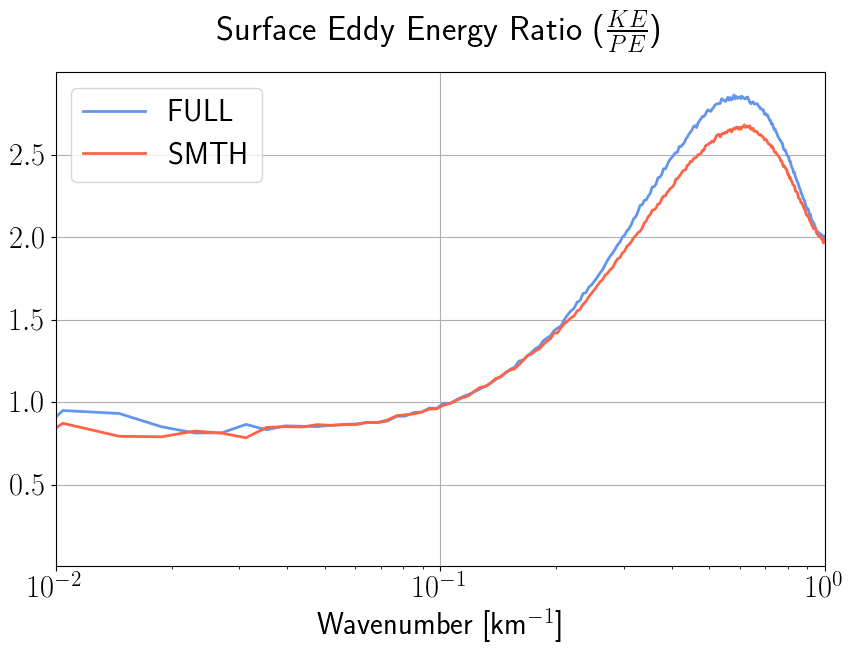

In [165]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'Surface Eddy Energy Ratio ($\frac{KE}{PE}$)',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PE-KE.png')


